In [7]:
import torch
from pathlib import Path

path = Path.cwd() / "input/comp_01_3132.pth"
file_name = path.stem
comp_dict = torch.load(path)

file_name

'comp_01_3132'

In [8]:
xyz = comp_dict['xyz']
feature = comp_dict['feature_dc_index']
cholesky = comp_dict['quant_cholesky_elements']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


print(xyz.shape)

torch.Size([3132, 2])


In [9]:
import math
def preprocess(data):
    result = []
    for X in data: 
        X_processed = X
        if X.shape[1] < 3:
            pad = torch.zeros(X.shape[0], 3 - X.shape[1], device=X.device)
            # 保证有3通道
            X_processed = torch.cat([X, pad], dim=1) 
        
        N, C = X_processed.shape

        # ---- Step 1: 原始 sqrt-based 尺寸 ----
        H = W = int(math.ceil(math.sqrt(N)))

        # ---- Step 2: 向上取整到 8 的倍数 ----
        def ceil_to_multiple(x, base=8):
            return int(math.ceil(x / base) * base)
        
        H = ceil_to_multiple(H, 8)
        W = ceil_to_multiple(W, 8)

        # ---- Step 3: padding 以填满 H×W ----
        pad_length = H * W - N
        if pad_length > 0:
            X_processed = torch.cat(
                [X_processed, torch.zeros(pad_length, C, device=X.device)], dim=0
            )

        # ---- Step 4: reshape 为 [1, C, 1, H, W] ----
        X_processed = X_processed.T.view(C, 1, H, W)
        mask = torch.zeros(1, 1, 1, H, W, device=X.device)
        mask[:, :, :, :int(math.sqrt(N)), :int(math.sqrt(N))] = 1
        result.append((X_processed.unsqueeze(0), mask))  # shape: (1, C, 1, H, W)
    
    return result

def convert_to_original(X, original_N, original_C):
    C, _, H, W = X.shape[1:]  # X shape: (1, C, 1, H, W)
    N = H * W
    X = X.view(C, N).T  # shape: (N, C)
    X = X[:original_N, :original_C] 
    return X

input_list = preprocess([xyz, feature, cholesky])
(input, mask)= input_list[0]
input.shape

torch.Size([1, 3, 1, 56, 56])

In [10]:
from models.guassian_iv_vae import IV_VAE

z_dim = 32
dim = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = IV_VAE(z_dim, dim).to(device=device, dtype=torch.float32)
vae.requires_grad_(False)
vae.eval()


IV_VAE(
  (model): VAutoencoder3d(
    (encoder): Encoder3d(
      (conv1): First_Sep_Conv3d(
        (conv_2d): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_3d): Group_Causal_Conv3d(3, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      )
      (downsamples): Sequential(
        (0): Sep_ResidualBlock(
          (residual): Sequential(
            (0): Sep_RMS_norm()
            (1): SiLU()
            (2): Sep_Conv3d(
              (conv_2d): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (conv_3d): Group_Causal_Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
            )
            (3): Sep_RMS_norm()
            (4): SiLU()
            (5): Dropout(p=0.0, inplace=False)
            (6): Sep_Conv3d(
              (conv_2d): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (conv_3d): Group_Causal_Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
            )
   

In [11]:
def chamfer_distance(pcd1, pcd2):
    if pcd1.ndim == 2:  # [N, 2]
        pcd1 = pcd1.unsqueeze(0)
        pcd2 = pcd2.unsqueeze(0)
    diff_1 = torch.cdist(pcd1, pcd2)
    min_1, _ = diff_1.min(dim=2)
    min_2, _ = diff_1.min(dim=1)
    return (min_1.mean(dim=1) + min_2.mean(dim=1)).mean()

def tensor_to_pointcloud(tensor):
    """
    tensor: [1, 3, 1, H, W]
    return: [N, 2]
    """
    B, C, D, H, W = tensor.shape
    tensor = tensor.view(B, C, -1)     # [1, 3, H*W]
    tensor = tensor.squeeze(0).T       # [H*W, 3]
    tensor = tensor.unsqueeze(0)  # [1, H*W, 3]
    return tensor[..., :2]  # return [1, N, 2]

def train(vae, input, mask, device, epochs=2000, lr=1e-4):
    """
    input: [1, 3, 1, H, W] 
    """
    vae = vae.to(device=device, dtype=torch.float32)
    vae.requires_grad_(True)
    optimizer = torch.optim.AdamW(vae.parameters(), lr=lr)

    best_loss = 0.0 
    for epoch in range(1, epochs + 1):
        vae.train()
        optimizer.zero_grad()

        # ---- Forward ----
        z = vae.encode(input)              # encode 已经返回 latent
        recon = vae.decode(z)              # decode 得到重建图像

        # ---- Loss ----
        # recon_pcd = tensor_to_pointcloud(recon)
        # target_pcd = tensor_to_pointcloud(input)
        # loss = chamfer_distance(target_pcd, recon_pcd)
        loss = ((recon - input)**2 * mask).sum() / mask.sum()
        
        # ---- Backward ----
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss or epoch == 1:
            best_loss = loss.item()
            best_model = vae.state_dict()

        if epoch % 20 == 0 or epoch == 1:
            print(f"\r[Train] epoch {epoch:4d}/{epochs} | loss={loss.item():.6f}", end='')
    vae.load_state_dict(best_model)
    vae.requires_grad_(False)
    print(f"\n[Result]Best loss: {best_loss:.6f}")
    return best_model


In [12]:
(input, mask) = input_list[2]
bestmodel = train(vae, input, mask, device, epochs=1000)

[Train] epoch 1000/1000 | loss=336.7056881
[Result]Best loss: 58.897427


In [13]:
with torch.no_grad():
    z = vae.encode(input)
    recon = vae.decode(z)
    print(recon.shape)

# Round to nearest integer *semantically*, keep float dtype
input_rounded = torch.round(input)
recon_rounded = torch.round(recon)

# Compute continuous MSE
loss = ((recon_rounded - input_rounded) ** 2 * mask).sum() / mask.sum() 
print(f"Final Reconstruction Loss (rounded MSE): {loss.item():.6f}")

torch.Size([1, 3, 1, 56, 56])
Final Reconstruction Loss (rounded MSE): 326.956360


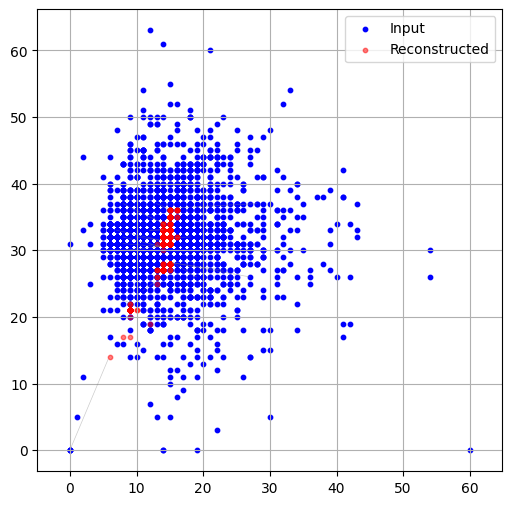

In [14]:
import matplotlib.pyplot as plt

input_pcd = tensor_to_pointcloud(input)
recon_pcd = tensor_to_pointcloud(recon)
pcd1 = input_pcd[0].detach().cpu()
pcd2 = recon_pcd[0].detach().cpu()

diff = torch.cdist(pcd1.unsqueeze(0), pcd2.unsqueeze(0))[0]
min_idx = diff.argmin(dim=1)

plt.figure(figsize=(6, 6))
plt.scatter(torch.round(pcd1[:, 0]), torch.round(pcd1[:, 1]), s=10, c='blue', label='Input')
plt.scatter(torch.round(pcd2[:, 0]), torch.round(pcd2[:, 1]), s=10, c='red', alpha=0.5, label='Reconstructed')

for i in torch.linspace(0, len(pcd1)-1, 20).long():
    plt.plot(
        [pcd1[i, 0], pcd2[min_idx[i], 0]],
        [pcd1[i, 1], pcd2[min_idx[i], 1]],
        'gray', linewidth=0.5, alpha=0.4
    )

plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

In [15]:
data_type = "cholesky"  # "xyz" or "feature" or "cholesky"

if Path.cwd().joinpath(f"ckpt/{data_type}").exists() is False:
    Path.cwd().joinpath(f"ckpt/{data_type}").mkdir(parents=True, exist_ok=True)

torch.save(vae.state_dict(), Path.cwd().joinpath(f"ckpt/{data_type}/{file_name}_zdim{z_dim}_dim{dim}.pth"))
print(z.shape)

torch.Size([1, 32, 1, 7, 7])


In [16]:
data_type = ["xyz", "feature", "cholesky"]
reconstructions = {}
for dtype in data_type:
    print(f"Loading and reconstructing for data type: {dtype}")
    model_path = Path.cwd().joinpath(f"ckpt/{dtype}/{file_name}_zdim{z_dim}_dim{dim}.pth")
    vae.load_state_dict(torch.load(model_path))
    vae.requires_grad_(False)
    with torch.no_grad():
        z = vae.encode(input)
        recon = vae.decode(z)
    if not dtype == "xyz":
        recon = torch.round(recon).int()
    if dtype == "cholesky":
        C = 3
    else:
        C = 2
    
    reconstructions[dtype] = convert_to_original(recon, 3000, C)
    
for key, value in reconstructions.items():
    print(f"{key} reconstruction shape: {value.shape}")

Loading and reconstructing for data type: xyz


KeyboardInterrupt: 

In [ ]:
reconstructions

{'xyz': tensor([[ 0.5945, -0.4472],
         [-0.1785,  0.4855],
         [-1.9248,  0.5329],
         ...,
         [ 0.0068,  0.1890],
         [-0.9810,  0.6977],
         [-0.0998, -1.1606]], device='cuda:0'),
 'feature': tensor([[2, 3],
         [3, 3],
         [5, 3],
         ...,
         [5, 3],
         [2, 3],
         [7, 5]], device='cuda:0', dtype=torch.int32),
 'cholesky': tensor([[ 6, 21,  2],
         [ 5, 24, 42],
         [10, 20, 13],
         ...,
         [11, 20,  3],
         [22, 22,  4],
         [ 7, 23, 20]], device='cuda:0', dtype=torch.int32)}

In [ ]:
comp_dict

{'xyz': tensor([[ 0.5938, -0.4473],
         [-0.1790,  0.4866],
         [-1.9248,  0.5337],
         ...,
         [ 0.0065,  0.1875],
         [-0.9824,  0.6973],
         [-0.0984, -1.1641]], device='cuda:0', dtype=torch.float16),
 'feature_dc_index': tensor([[2, 3],
         [3, 3],
         [5, 3],
         ...,
         [5, 3],
         [2, 3],
         [7, 5]], device='cuda:0'),
 'quant_cholesky_elements': tensor([[ 6., 21.,  2.],
         [ 5., 24., 42.],
         [10., 20., 13.],
         ...,
         [11., 20.,  3.],
         [22., 22.,  4.],
         [ 7., 23., 20.]], device='cuda:0')}

In [ ]:
torch.save(reconstructions, Path.cwd().joinpath(f"results/gaussians/{file_name}_zdim{z_dim}_dim{dim}_recon.pth"))